In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from numpy import genfromtxt
import matplotlib.pyplot as plt
import time
import os
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import array
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.cluster import AffinityPropagation

In [3]:
tf.__version__

'2.2.0'

In [6]:
use_gpu = True 
if use_gpu :
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))
    os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"]="0"
    

Num GPUs Available:  1


# Agumentation

In [3]:
def gene_filtering(genepath):    

    # Ensembl ID
    gnames = np.array(pd.read_csv(genepath))[:,0]
    
    # Gene symbol : gene name
    glists = np.array(pd.read_csv(genepath))[:,1]

    return gnames, glists

In [4]:
def extract_filtered_gene(datapath, gnames):
    
    #Load dataset
    rld = np.genfromtxt(datapath, delimiter = ',', dtype = 'str')
    label, gene, value = rld[0][1:], rld[1:,0], rld[1:,1:].T
    label = np.array([x.replace('"', '') for x in label])
    gene = np.array([x.replace('"', '') for x in gene])
    value = value.astype(np.float32)

    #Extract filtered genes
    eidx = []
    for g in range(len(gnames)):
        idx = np.where(gnames[g] == gene)[0][0]
        eidx.append(idx)

    evalue, egene = value[:, eidx], gnames
    return evalue, egene, label

In [5]:
def data_augmentation(evalue, egene, elabel, save=True):

    aug_values = []
    aug_labels = []    
    sp_size = 5    
    n_age = 2
    n_treatment = 2
        
    for ti in range(n_age): #time
        
        for tr in range(n_treatment): #treatment
            #
            for s in range(sp_size): #samples
                s1 = ti*10+tr*5+s
                for s_ in range(s, sp_size):
                    s2 = ti*10+tr*5+s_
                    tmp1, tmp2 = evalue[s1], evalue[s2]
                    if(s==s_): #rawdata
                        aug_values.append(tmp1)
                        aug_labels.append(elabel[s1])
                    else: #augmentation
                        for r in range(9):
                            augx = tmp1*(r+1)*0.1+tmp2*(9-r)*0.1
                            aug_values.append(augx)
                            aug_labels.append(elabel[s1]+'+'+elabel[s2]+'+'+str(r+1))
                            
    aug_values, aug_labels = np.array(aug_values), np.array(aug_labels),

    #save
    if save==True:
        np.savez('augmented_input_Tau_Union_LFC03_3767G_re.npz', genelist=egene, values=aug_values, 
                 labels=aug_labels)
        print ('Augmented input is saved!')
    
    return [egene, aug_values, aug_labels]

In [6]:
#Rerun Augmentation?
re_data_augmentation = True
is_training=True
is_interpolation = True

# 1. Preprocess dataset

In [7]:
##Gene filtering and augmentation



if re_data_augmentation : 
    gene_path = 'Tau_Union_rld_LFC03_remove_all_case_3767genes.csv'
    ex_gnames, ex_glists = gene_filtering(gene_path)
    ex_value, ex_gene, ex_label = extract_filtered_gene(gene_path, ex_gnames)
    augmented_data = data_augmentation(ex_value, ex_glists, ex_label, True)
    input_ = 'augmented_input_Tau_Union_LFC03_3767G_re.npz'
else : 
    input_ = 'augmented_input_Tau_Union_LFC03_3767G.npz'
    
dat = np.load(input_,allow_pickle=True)
rlds, genelist, augsample = dat['values'], dat['genelist'], dat['labels']
realidx = [0, 95, 190, 285]

print (rlds.shape)

Augmented input is saved!
(380, 3767)


In [8]:
# Label Indexing

WT3M = np.array([0,37,65,84,94])
AD3M = np.add(WT3M, 95)
WT6M = np.add(WT3M, 2*95)
AD6M = np.add(WT3M, 3*95)
Aug_WT3M = np.arange(95)
Aug_AD3M = np.add(Aug_WT3M,95)
Aug_WT6M = np.add(Aug_WT3M,2*95)
Aug_AD6M = np.add(Aug_WT3M,3*95)

# 2. Rescaling(normalization)

In [9]:
cond_list = [Aug_WT3M, Aug_WT6M, Aug_AD3M, Aug_AD6M]

rld_mean = np.average(rlds, axis=0)
rld_median = np.median(rlds, axis=0)
rld_std = np.zeros((len(cond_list),rlds.shape[1]))

for c in range(len(cond_list)):
    rld_std[c] = np.std(rlds[cond_list[c]], axis=0)

max_rld_std = np.max(rld_std, axis=0)
avg_rld_std = np.average(rld_std, axis=0)
all_rld_std = np.std(rlds,axis=0)

[]

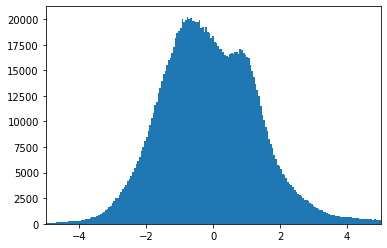

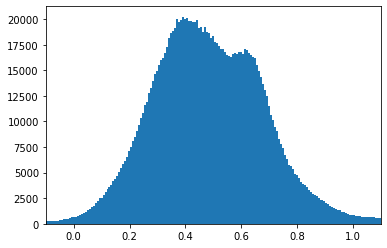

In [10]:
##IQR filter 

num_q1, num_q3 = 25, 75 

all_q1 = stats.scoreatpercentile(all_rld_std, num_q1)
max_q1 = stats.scoreatpercentile(max_rld_std, num_q1)

all_q3 = stats.scoreatpercentile(all_rld_std, num_q3)
max_q3 = stats.scoreatpercentile(max_rld_std, num_q3)

all_rld_std_filter = np.where(all_rld_std<all_q1,all_q1,all_rld_std)
all_rld_std_filter_f = np.where(all_rld_std>all_q3,all_q3,all_rld_std_filter)

max_rld_std_filter = np.where(max_rld_std<max_q1,max_q1,max_rld_std) 
max_rld_std_filter_f=np.where(max_rld_std>max_q3,max_q3,max_rld_std_filter) 

two_rld_std_f = []
two_rld_std_f.append(all_rld_std_filter_f)
two_rld_std_f.append(max_rld_std_filter_f)
two_rld_std_f = np.array(two_rld_std_f)

gmean_rld_std_f = stats.gmean(two_rld_std_f,axis=0)

re_rld_f = (rlds-rld_mean)/gmean_rld_std_f

plt.figure()
plt.hist(re_rld_f.flatten(), bins=1000)
plt.xlim(-5, 5)
plt.plot()  

std_re_rld_f = np.std(re_rld_f.flatten())

### Within 95% 
re_rld_norm_f = re_rld_f/(2*1.959*std_re_rld_f)+0.5

rld = re_rld_norm_f

plt.figure()
plt.hist(re_rld_norm_f.flatten(), bins=1000)
plt.xlim(-0.1, 1.1)
plt.plot()  

# 3. Training networks setting

In [11]:
#split training and test dataset

nrld = rld.flatten()
te_ratio = 0.1

x_idx = np.arange(len(rld))
te_idx = np.random.choice(len(rld), int(len(rld)*te_ratio), False)
tr_idx = np.setdiff1d(x_idx, te_idx)
xtr, xte = rld[tr_idx], rld[te_idx]
tr_max = np.max(xtr)
n_tr, n_te = len(xtr), len(xte)

print ('xtr:', xtr.shape, ', xte:', xte.shape)
n, p = xtr.shape
print(n ,p)

xtr: (342, 3767) , xte: (38, 3767)
342 3767


In [12]:
print(rld)

[[0.47845441 0.65699117 0.62883687 ... 0.50901046 0.4375826  0.4316747 ]
 [0.63932166 0.34072481 0.54000632 ... 0.35631632 0.57578993 0.41287942]
 [0.62144787 0.37586502 0.54987654 ... 0.37328233 0.56043333 0.41496716]
 ...
 [0.29840336 0.44373418 0.68064224 ... 0.65114466 0.16041546 0.80747162]
 [0.3006681  0.42249193 0.66892403 ... 0.65521243 0.13858759 0.8111452 ]
 [0.28028227 0.61366835 0.77439122 ... 0.61861029 0.33503636 0.77807363]]


In [13]:
#Hyperparameter setting

lr = 1e-5                        # Learning rate
EPOCHS = 300000                  # Epochs to train
critic = 5                       # Critic updates per generator update 
gradient_penalty_weight = 10.0
BUFFER_SIZE = 20
BATCH_SIZE = 32

# Number of generator hidden layer units & Number of discriminator hidden layer units
gen_size, disc_size = 450, 270
rld = rld.astype('float32')
rld_max = np.max(rld)
train_dataset = tf.data.Dataset.from_tensor_slices(rld).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [14]:
# optimizer setting

generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

In [15]:
# Setting the training data directory

log_dir="training_data/"
sub_path = log_dir + "Tau_union_LFC03_G3767_G450D270_300k/" + "20210309_1"

if is_training :
    # Set the directory to save the training data 
    sub_path = log_dir + "Tau_union_LFC03_G3767_G450D270_300k/" + "yours_dir"
    summary_writer = tf.summary.create_file_writer(sub_path)

In [16]:
noise_dim = 100
nrld = rld.flatten()

def get_noise(batch_size):
    seed = nrld[np.random.randint(0,len(nrld),size=(batch_size, noise_dim))]
    seed = tf.convert_to_tensor(seed)
    return seed

idx_ = np.random.choice(n_tr, BATCH_SIZE, replace=False)

In [17]:
gen_init=0.3
def make_generator_model():
    model = keras.Sequential([
        layers.Dense(gen_size, input_shape=(noise_dim, ), 
                     kernel_initializer=tf.random_uniform_initializer(-gen_init,gen_init)),
        layers.LeakyReLU(),
        layers.Dense(gen_size, kernel_initializer=tf.random_uniform_initializer(-gen_init,gen_init)),
        layers.LeakyReLU(),
        layers.Dense(p, kernel_initializer=tf.random_uniform_initializer(-gen_init,gen_init))
    ])
    return model

generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 450)               45450     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 450)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 450)               202950    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 450)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3767)              1698917   
Total params: 1,947,317
Trainable params: 1,947,317
Non-trainable params: 0
_________________________________________________________________


In [18]:
noise = get_noise(1)
generated_rlds = generator(noise, training=False)

In [19]:
def make_discriminator_model():
    model = keras.Sequential([
        layers.Dense(disc_size, input_shape=(p, )),
        layers.LeakyReLU(),
        layers.Dense(disc_size),
        layers.LeakyReLU(),
        layers.Dense(1)
    ])   
    return model

discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 270)               1017360   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 270)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 270)               73170     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 270)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 271       
Total params: 1,090,801
Trainable params: 1,090,801
Non-trainable params: 0
_________________________________________________________________


In [20]:
decision = discriminator(generated_rlds)

In [21]:
checkpoint_dir = sub_path + "/training_checkpoints"
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

print(checkpoint_dir)

training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints


In [22]:
@tf.function
def train_gen(rlds, noise):
    #batch_size = rlds.get_shape().as_list()[0]
    
    with tf.GradientTape() as t:
        #noise = get_noise(batch_size)
        generated_rlds = generator(noise, training=True)
        fake_output = discriminator(generated_rlds, training=True)
        
        loss = generator_loss(fake_output)
    gradients = t.gradient(loss, generator.trainable_variables)
   
    generator_optimizer.apply_gradients(zip(gradients, generator.trainable_variables))
    return loss

In [23]:
@tf.function
def train_disc(rlds, noise):
    #batch_size = rlds.get_shape().as_list()[0]
    
        
    with tf.GradientTape() as t:
        
        generated_rlds = generator(noise, training=True)
        fake_output = discriminator(generated_rlds, training=True)
        real_output = discriminator(rlds, training=True)
        
        gp = gradient_penalty(rlds, generated_rlds)
        loss = discriminator_loss(fake_output, real_output) + gp
        gradients = t.gradient(loss, discriminator.trainable_variables)
           
    discriminator_optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))
    return loss 

In [24]:
def generator_loss(fake_output):
    fake_loss = -tf.reduce_mean(fake_output)
    return fake_loss

def discriminator_loss(fake_output, real_output):
    fake_loss = tf.reduce_mean(fake_output)
    real_loss = tf.reduce_mean(real_output)
    return fake_loss - real_loss

In [25]:
# gradient penalty 
def gradient_penalty(rlds, generated_rlds):
    batch_size = rlds.get_shape().as_list()[0]
    epsilon = tf.random.uniform (shape=[batch_size, 1], minval=0., maxval=rld_max)
    x_hat = (epsilon * rlds) + ((1 - epsilon) * generated_rlds)
    #x_hat = (epsilon * generated_rlds) + ((1 - epsilon) * rlds)
    with tf.GradientTape() as gp:
        gp.watch(x_hat)
        d_hat = discriminator(x_hat, training=True)
    gradients = gp.gradient(d_hat, [x_hat])[0]
    d_gradient = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=1))
    d_regularizer = gradient_penalty_weight * tf.reduce_mean(tf.square(d_gradient-1.))
    return d_regularizer 

In [26]:
if is_training :
    gen_loss_results = []
    disc_loss_results = []
    gen_rlds = []

    start = time.time()
    num_to_generate = 84

    for epoch in range(EPOCHS):
        epoch_gen_loss_avg = tf.keras.metrics.Mean()
        epoch_disc_loss_avg = tf.keras.metrics.Mean()

        for batch in train_dataset:
            noise = get_noise(batch.shape[0])
            for _ in range (critic):
                #train_disc(batch)
                d_loss = train_disc(batch, noise)           
                epoch_disc_loss_avg(d_loss)
            g_loss = train_gen(batch, noise)
            epoch_gen_loss_avg(g_loss)
            #train_gen(batch)

        gen_loss_results.append(epoch_gen_loss_avg.result())
        disc_loss_results.append(epoch_disc_loss_avg.result())

        if (epoch + 1) % 500 == 0:
            checkpoint_prefix = checkpoint_dir + "/cp-" + str(epoch+1) + '.ckpt'
            checkpoint.save(file_prefix = checkpoint_prefix) 
            print("Saving checkpoint for epoch{} at {}".format(epoch+1, checkpoint_prefix))

            predictions = generator(get_noise(num_to_generate), training=False)
            gen_rlds.append(predictions.numpy())
            print("Epoch {:03d}: Gen_Loss: {:.3f}, Disc_Loss: {:.3f}". format(epoch+1, 
                                                                      epoch_gen_loss_avg.result(),
                                                                      epoch_disc_loss_avg.result()))

        #epoch_gen_loss_avg.reset_states()
        #epoch_disc_loss_avg.reset_states()

        with summary_writer.as_default():
            tf.summary.scalar('gen_loss', epoch_gen_loss_avg.result(), step=epoch)
            tf.summary.scalar('disc_loss', epoch_disc_loss_avg.result(), step=epoch)

    elapsed_time = time.time() - start
    hours, rem = divmod(elapsed_time, 3600)
    minutes, seconds = divmod(rem, 60)
    print ("Elapsed time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

    predictions = generator(get_noise(num_to_generate), training=False)
    gen_rlds.append(predictions.numpy())
    gen_x_84 = np.array(gen_rlds)
    np.savez(sub_path+'/Loss_GenX84.npz', gen_x_84=gen_x_84,disc_loss=disc_loss_results,gen_loss=gen_loss_results) 

Saving checkpoint for epoch500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-500.ckpt
Epoch 500: Gen_Loss: 197.746, Disc_Loss: -123.949
Saving checkpoint for epoch1000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-1000.ckpt
Epoch 1000: Gen_Loss: 59.427, Disc_Loss: -42.580
Saving checkpoint for epoch1500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-1500.ckpt
Epoch 1500: Gen_Loss: 36.662, Disc_Loss: -29.184
Saving checkpoint for epoch2000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-2000.ckpt
Epoch 2000: Gen_Loss: 24.564, Disc_Loss: -19.868
Saving checkpoint for epoch2500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-2500.ckpt
Epoch 2500: Gen_Loss: 16.776, Disc_Loss: -14.536
Saving checkpoint for epoch3000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpo

Saving checkpoint for epoch23500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-23500.ckpt
Epoch 23500: Gen_Loss: 14.044, Disc_Loss: -5.802
Saving checkpoint for epoch24000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-24000.ckpt
Epoch 24000: Gen_Loss: 14.394, Disc_Loss: -5.287
Saving checkpoint for epoch24500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-24500.ckpt
Epoch 24500: Gen_Loss: 12.661, Disc_Loss: -5.088
Saving checkpoint for epoch25000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-25000.ckpt
Epoch 25000: Gen_Loss: 12.632, Disc_Loss: -5.644
Saving checkpoint for epoch25500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-25500.ckpt
Epoch 25500: Gen_Loss: 11.728, Disc_Loss: -5.433
Saving checkpoint for epoch26000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/trai

Saving checkpoint for epoch46500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-46500.ckpt
Epoch 46500: Gen_Loss: 3.680, Disc_Loss: -4.824
Saving checkpoint for epoch47000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-47000.ckpt
Epoch 47000: Gen_Loss: 3.224, Disc_Loss: -4.619
Saving checkpoint for epoch47500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-47500.ckpt
Epoch 47500: Gen_Loss: 4.105, Disc_Loss: -4.262
Saving checkpoint for epoch48000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-48000.ckpt
Epoch 48000: Gen_Loss: 4.234, Disc_Loss: -4.622
Saving checkpoint for epoch48500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-48500.ckpt
Epoch 48500: Gen_Loss: 5.333, Disc_Loss: -4.781
Saving checkpoint for epoch49000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_

Saving checkpoint for epoch69500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-69500.ckpt
Epoch 69500: Gen_Loss: 2.829, Disc_Loss: -3.274
Saving checkpoint for epoch70000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-70000.ckpt
Epoch 70000: Gen_Loss: 3.093, Disc_Loss: -3.424
Saving checkpoint for epoch70500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-70500.ckpt
Epoch 70500: Gen_Loss: 2.759, Disc_Loss: -3.806
Saving checkpoint for epoch71000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-71000.ckpt
Epoch 71000: Gen_Loss: 1.847, Disc_Loss: -3.359
Saving checkpoint for epoch71500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-71500.ckpt
Epoch 71500: Gen_Loss: 1.180, Disc_Loss: -3.567
Saving checkpoint for epoch72000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_

Saving checkpoint for epoch92500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-92500.ckpt
Epoch 92500: Gen_Loss: 0.056, Disc_Loss: -3.278
Saving checkpoint for epoch93000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-93000.ckpt
Epoch 93000: Gen_Loss: 1.749, Disc_Loss: -2.871
Saving checkpoint for epoch93500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-93500.ckpt
Epoch 93500: Gen_Loss: 0.923, Disc_Loss: -3.000
Saving checkpoint for epoch94000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-94000.ckpt
Epoch 94000: Gen_Loss: 1.056, Disc_Loss: -2.884
Saving checkpoint for epoch94500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-94500.ckpt
Epoch 94500: Gen_Loss: 2.168, Disc_Loss: -2.927
Saving checkpoint for epoch95000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_

Saving checkpoint for epoch115500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-115500.ckpt
Epoch 115500: Gen_Loss: 1.662, Disc_Loss: -2.701
Saving checkpoint for epoch116000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-116000.ckpt
Epoch 116000: Gen_Loss: 0.302, Disc_Loss: -2.612
Saving checkpoint for epoch116500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-116500.ckpt
Epoch 116500: Gen_Loss: 0.297, Disc_Loss: -2.711
Saving checkpoint for epoch117000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-117000.ckpt
Epoch 117000: Gen_Loss: 0.965, Disc_Loss: -2.721
Saving checkpoint for epoch117500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-117500.ckpt
Epoch 117500: Gen_Loss: 0.509, Disc_Loss: -2.466
Saving checkpoint for epoch118000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/you

Saving checkpoint for epoch138000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-138000.ckpt
Epoch 138000: Gen_Loss: -0.366, Disc_Loss: -2.152
Saving checkpoint for epoch138500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-138500.ckpt
Epoch 138500: Gen_Loss: -0.600, Disc_Loss: -2.443
Saving checkpoint for epoch139000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-139000.ckpt
Epoch 139000: Gen_Loss: 0.716, Disc_Loss: -2.792
Saving checkpoint for epoch139500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-139500.ckpt
Epoch 139500: Gen_Loss: 0.294, Disc_Loss: -2.471
Saving checkpoint for epoch140000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-140000.ckpt
Epoch 140000: Gen_Loss: -0.545, Disc_Loss: -2.400
Saving checkpoint for epoch140500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/

Saving checkpoint for epoch160500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-160500.ckpt
Epoch 160500: Gen_Loss: 0.066, Disc_Loss: -2.235
Saving checkpoint for epoch161000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-161000.ckpt
Epoch 161000: Gen_Loss: -1.266, Disc_Loss: -2.103
Saving checkpoint for epoch161500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-161500.ckpt
Epoch 161500: Gen_Loss: 0.319, Disc_Loss: -2.443
Saving checkpoint for epoch162000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-162000.ckpt
Epoch 162000: Gen_Loss: -0.525, Disc_Loss: -2.181
Saving checkpoint for epoch162500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-162500.ckpt
Epoch 162500: Gen_Loss: -0.388, Disc_Loss: -2.170
Saving checkpoint for epoch163000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/

Saving checkpoint for epoch183000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-183000.ckpt
Epoch 183000: Gen_Loss: -0.587, Disc_Loss: -2.196
Saving checkpoint for epoch183500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-183500.ckpt
Epoch 183500: Gen_Loss: -0.712, Disc_Loss: -2.007
Saving checkpoint for epoch184000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-184000.ckpt
Epoch 184000: Gen_Loss: -0.355, Disc_Loss: -2.205
Saving checkpoint for epoch184500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-184500.ckpt
Epoch 184500: Gen_Loss: -0.387, Disc_Loss: -1.947
Saving checkpoint for epoch185000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-185000.ckpt
Epoch 185000: Gen_Loss: -0.234, Disc_Loss: -2.044
Saving checkpoint for epoch185500 at training_data/Tau_union_LFC03_G3767_G450D270_300

Saving checkpoint for epoch205500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-205500.ckpt
Epoch 205500: Gen_Loss: -0.786, Disc_Loss: -2.012
Saving checkpoint for epoch206000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-206000.ckpt
Epoch 206000: Gen_Loss: 0.007, Disc_Loss: -2.040
Saving checkpoint for epoch206500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-206500.ckpt
Epoch 206500: Gen_Loss: -0.208, Disc_Loss: -1.897
Saving checkpoint for epoch207000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-207000.ckpt
Epoch 207000: Gen_Loss: -0.783, Disc_Loss: -1.805
Saving checkpoint for epoch207500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-207500.ckpt
Epoch 207500: Gen_Loss: -0.528, Disc_Loss: -1.912
Saving checkpoint for epoch208000 at training_data/Tau_union_LFC03_G3767_G450D270_300k

Saving checkpoint for epoch228000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-228000.ckpt
Epoch 228000: Gen_Loss: -0.245, Disc_Loss: -2.016
Saving checkpoint for epoch228500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-228500.ckpt
Epoch 228500: Gen_Loss: -0.956, Disc_Loss: -1.900
Saving checkpoint for epoch229000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-229000.ckpt
Epoch 229000: Gen_Loss: -0.061, Disc_Loss: -2.180
Saving checkpoint for epoch229500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-229500.ckpt
Epoch 229500: Gen_Loss: -0.987, Disc_Loss: -2.116
Saving checkpoint for epoch230000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-230000.ckpt
Epoch 230000: Gen_Loss: -0.353, Disc_Loss: -1.985
Saving checkpoint for epoch230500 at training_data/Tau_union_LFC03_G3767_G450D270_300

Saving checkpoint for epoch250500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-250500.ckpt
Epoch 250500: Gen_Loss: -0.537, Disc_Loss: -1.832
Saving checkpoint for epoch251000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-251000.ckpt
Epoch 251000: Gen_Loss: -1.547, Disc_Loss: -1.829
Saving checkpoint for epoch251500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-251500.ckpt
Epoch 251500: Gen_Loss: 0.354, Disc_Loss: -1.909
Saving checkpoint for epoch252000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-252000.ckpt
Epoch 252000: Gen_Loss: -1.185, Disc_Loss: -1.788
Saving checkpoint for epoch252500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-252500.ckpt
Epoch 252500: Gen_Loss: -0.736, Disc_Loss: -1.928
Saving checkpoint for epoch253000 at training_data/Tau_union_LFC03_G3767_G450D270_300k

Saving checkpoint for epoch273000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-273000.ckpt
Epoch 273000: Gen_Loss: -0.347, Disc_Loss: -1.973
Saving checkpoint for epoch273500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-273500.ckpt
Epoch 273500: Gen_Loss: -1.601, Disc_Loss: -1.678
Saving checkpoint for epoch274000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-274000.ckpt
Epoch 274000: Gen_Loss: 0.420, Disc_Loss: -1.991
Saving checkpoint for epoch274500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-274500.ckpt
Epoch 274500: Gen_Loss: -0.915, Disc_Loss: -1.728
Saving checkpoint for epoch275000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-275000.ckpt
Epoch 275000: Gen_Loss: -1.585, Disc_Loss: -1.701
Saving checkpoint for epoch275500 at training_data/Tau_union_LFC03_G3767_G450D270_300k

Saving checkpoint for epoch295500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-295500.ckpt
Epoch 295500: Gen_Loss: -0.857, Disc_Loss: -1.695
Saving checkpoint for epoch296000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-296000.ckpt
Epoch 296000: Gen_Loss: -1.156, Disc_Loss: -1.817
Saving checkpoint for epoch296500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-296500.ckpt
Epoch 296500: Gen_Loss: -2.181, Disc_Loss: -1.867
Saving checkpoint for epoch297000 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-297000.ckpt
Epoch 297000: Gen_Loss: -0.825, Disc_Loss: -1.754
Saving checkpoint for epoch297500 at training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-297500.ckpt
Epoch 297500: Gen_Loss: -0.432, Disc_Loss: -1.724
Saving checkpoint for epoch298000 at training_data/Tau_union_LFC03_G3767_G450D270_300

In [27]:
Reload_LossGenX = np.load(sub_path+'/Loss_GenX84.npz')
Rel_gen_x_84 = Reload_LossGenX['gen_x_84'] 
Rel_disc_loss = Reload_LossGenX['disc_loss']
Rel_gen_loss = Reload_LossGenX['gen_loss']
print(Rel_gen_x_84.shape, np.shape(Rel_disc_loss), np.shape(Rel_gen_loss))

(601, 84, 3767) (300000,) (300000,)


In [28]:
gen_x, disc_loss_results, gen_loss_results = Rel_gen_x_84, Rel_disc_loss, Rel_gen_loss

[]

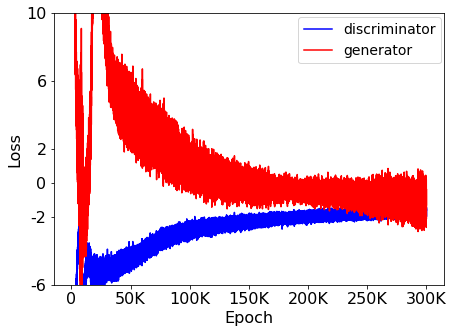

In [29]:
# plot training loss graph
plt.figure(figsize=(7,5))
plt.plot(disc_loss_results, c='blue', label='discriminator')
plt.plot(gen_loss_results, c='red', label='generator')
plt.legend(loc=1, fontsize=14, bbox_to_anchor=(1.01,1.01))
plt.ylim(-6.0,10.0)
plt.yticks([-6,-2,0,2,6,10], ['-6', '-2', '0', '2', '6', '10'], fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.xticks(np.arange(0, 350000, 50000), ['0', '50K','100K','150K', '200K', '250K', '300K'], 
           fontsize=16)
plt.plot()

In [30]:
# Plot tSNE
initx = np.concatenate((rld, gen_x[100]), axis=0)
med1x = np.concatenate((rld, gen_x[200]), axis=0) #100K
med2x = np.concatenate((rld, gen_x[400]), axis=0) #200K
endx = np.concatenate((rld, gen_x[600]), axis=0)  #300K
print (initx.shape, med1x.shape, med2x.shape, endx.shape)

tsne = TSNE()
tsne_init = tsne.fit_transform(initx)
tsne_med1 = tsne.fit_transform(med1x)
tsne_med2 = tsne.fit_transform(med2x)
tsne_end = tsne.fit_transform(endx)
print (tsne_init.shape, tsne_med1.shape, tsne_med2.shape, tsne_end.shape)
print (len(rld), len(gen_x[0]))
n_rld = len(rld)
n_gen = len(gen_x)

(464, 3767) (464, 3767) (464, 3767) (464, 3767)
(464, 2) (464, 2) (464, 2) (464, 2)
380 84


([], <a list of 0 Text major ticklabel objects>)

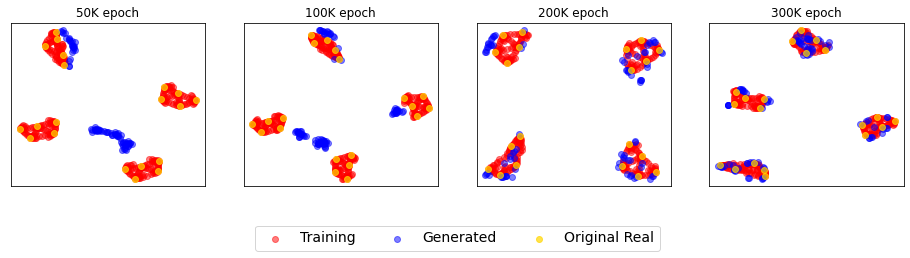

In [31]:
plt.figure(figsize=(16,3))

plt.subplot(141)
plt.title("50K epoch")
plt.scatter(tsne_init[:n_rld,0], tsne_init[:n_rld,1], alpha=0.5, c='red')
plt.scatter(tsne_init[n_rld:n_rld+n_gen,0], tsne_init[n_rld:n_rld+n_gen,1], alpha=0.5, c='blue')
plt.scatter(tsne_init[WT3M,0], tsne_init[WT3M,1], alpha=0.7, c='gold')
plt.scatter(tsne_init[AD3M,0], tsne_init[AD3M,1], alpha=0.7, c='gold')
plt.scatter(tsne_init[WT6M,0], tsne_init[WT6M,1], alpha=0.7, c='gold')
plt.scatter(tsne_init[AD6M,0], tsne_init[AD6M,1], alpha=0.7, c='gold')
plt.xticks([])
plt.yticks([])

plt.subplot(142)
plt.title("100K epoch")
plt.scatter(tsne_med1[:n_rld,0], tsne_med1[:n_rld,1], alpha=0.5, c='red')
plt.scatter(tsne_med1[n_rld:n_rld+n_gen,0], tsne_med1[n_rld:n_rld+n_gen,1], alpha=0.5, c='blue')
plt.scatter(tsne_med1[WT3M,0], tsne_med1[WT3M,1], alpha=0.7, c='gold')
plt.scatter(tsne_med1[AD3M,0], tsne_med1[AD3M,1], alpha=0.7, c='gold')
plt.scatter(tsne_med1[WT6M,0], tsne_med1[WT6M,1], alpha=0.7, c='gold')
plt.scatter(tsne_med1[AD6M,0], tsne_med1[AD6M,1], alpha=0.7, c='gold')
plt.xticks([])
plt.yticks([])

plt.subplot(143)
plt.title("200K epoch")
plt.scatter(tsne_med2[:n_rld,0], tsne_med2[:n_rld,1], alpha=0.5, c='red')
plt.scatter(tsne_med2[n_rld:n_rld+n_gen,0], tsne_med2[n_rld:n_rld+n_gen,1], alpha=0.5, c='blue')
plt.scatter(tsne_med2[WT3M,0], tsne_med2[WT3M,1], alpha=0.7, c='gold')
plt.scatter(tsne_med2[AD3M,0], tsne_med2[AD3M,1], alpha=0.7, c='gold')
plt.scatter(tsne_med2[WT6M,0], tsne_med2[WT6M,1], alpha=0.7, c='gold')
plt.scatter(tsne_med2[AD6M,0], tsne_med2[AD6M,1], alpha=0.7, c='gold')
plt.xticks([])
plt.yticks([])

plt.subplot(144)
plt.title("300K epoch")
plt.scatter(tsne_end[:n_rld,0], tsne_end[:n_rld,1], alpha=0.5, c='red')
plt.scatter(tsne_end[n_rld:n_rld+n_gen,0], tsne_end[n_rld:n_rld+n_gen,1], alpha=0.5, c='blue')
plt.scatter(tsne_end[WT3M,0], tsne_end[WT3M,1], alpha=0.7, c='gold')
plt.scatter(tsne_end[AD3M,0], tsne_end[AD3M,1], alpha=0.7, c='gold')
plt.scatter(tsne_end[WT6M,0], tsne_end[WT6M,1], alpha=0.7, c='gold')
plt.scatter(tsne_end[AD6M,0], tsne_end[AD6M,1], alpha=0.7, c='gold')
plt.legend(['Training','Generated', 'Original Real'], ncol=3, bbox_to_anchor=(-.22, -.2), fontsize=14)
plt.xticks([])
plt.yticks([])

In [32]:
n_noise = 10000
  
Fake10000z = get_noise(n_noise)
Fake10000 = generator(Fake10000z, training=False)
print(generator.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 450)               45450     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 450)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 450)               202950    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 450)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3767)              1698917   
Total params: 1,947,317
Trainable params: 1,947,317
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
#if is_training :
#generate augx for all samples
#caluclate Corr(fake_x, xte)
fake_real_corr = np.zeros((n_rld,))
Fakeallz, Fakeallx = np.zeros((n_rld,Fake10000z.shape[1])), np.zeros((n_rld,Fake10000.shape[1]))
print (fake_real_corr.shape)

genaugx = []
for i in range(n_rld):
    scorr_ary = np.zeros((n_noise,))
    tmp1 = rld[i]
    for j in range(n_noise):
        tmp2 = Fake10000[j]
        scorr_ary[j] = stats.pearsonr(tmp1, tmp2)[0]
    smaxidx = np.argsort(scorr_ary)[-10:]

    Fakeallz[i] = np.average(tf.gather(Fake10000z, smaxidx), axis=0)
    Fakeallx[i] = generator(np.reshape(Fakeallz[i], (1, 100)), training=False)
    fake_real_corr[i] = stats.pearsonr(tmp1, Fakeallx[i])[0]
    genaugx.append(Fakeallx[i])
genaugx = np.array(genaugx)
genaugx = genaugx.reshape((rld.shape))
print(genaugx.shape)
#save value
np.savez(sub_path+'/FakeAll_atEnd.npz', fake_real_corr=fake_real_corr,Fakeallx=Fakeallx,genaugx=genaugx) 

(380,)
(380, 3767)


In [34]:
Reload_FakeA_atE = np.load(sub_path+'/FakeAll_atEnd.npz')
Rel_fake_real_corr, Rel_Fakeallx, Rel_genaugx = Reload_FakeA_atE['fake_real_corr'],Reload_FakeA_atE['Fakeallx'],Reload_FakeA_atE['genaugx']
print(Rel_fake_real_corr.shape, np.shape(Rel_Fakeallx), np.shape(Rel_genaugx))

(380,) (380, 3767) (380, 3767)


In [35]:
fake_real_corr, Fakeallx, genaugx = Rel_fake_real_corr, Rel_Fakeallx, Rel_genaugx

0.8912514190652411


[]

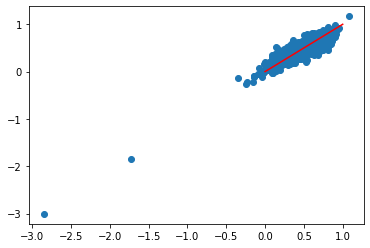

In [36]:
print(np.min(fake_real_corr,axis=0))
real_min = np.argmin(fake_real_corr)
plt.scatter(Fakeallx[real_min],rld[real_min])
plt.plot([0,1],color='red')
plt.plot()

0.9944641326650073


[]

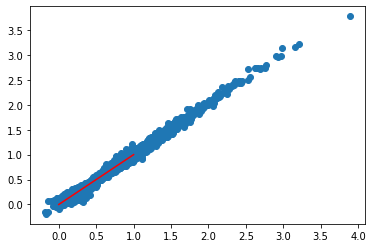

In [37]:
print(np.max(fake_real_corr,axis=0))
real_max = np.argmax(fake_real_corr)
plt.scatter(Fakeallx[real_max],rld[real_max])
plt.plot([0,1],color='red')
plt.plot()

In [38]:
def plot_hist_re_rld(real, fake, bins):
    plt.figure(figsize=(20,7))
    plt.suptitle('Histogram of rescaled RLD', fontsize=36, y=1.03)
    plt.subplot(121)
    plt.hist(real.flatten(), bins=bins)
    plt.xlim(-0.1, 1.1)
    plt.ylim(0, 10000)
    plt.xticks(fontsize=34)
    plt.yticks([])
    plt.xlabel('Rescaled RLD', fontsize=35)
    plt.ylabel('Counts', fontsize=35)
    plt.title('Real', fontsize=35)

    plt.subplot(122)
    plt.subplots_adjust(wspace=0.05)
    plt.hist(fake.flatten(), bins=bins, color='red')
    plt.xlim(-0.1, 1.1)
    plt.ylim(0, 10000)
    plt.xticks(fontsize=34)
    plt.yticks([])
    plt.xlabel('Rescaled RLD', fontsize=35)
    plt.title('Generated', fontsize=35)
    publish_save_dir = 'publish_data/'
    file_name = 'histogram_RLD.jpeg'

    plt.savefig(publish_save_dir+file_name, bbox_inches='tight',  pad_inches=0, dpi=300)

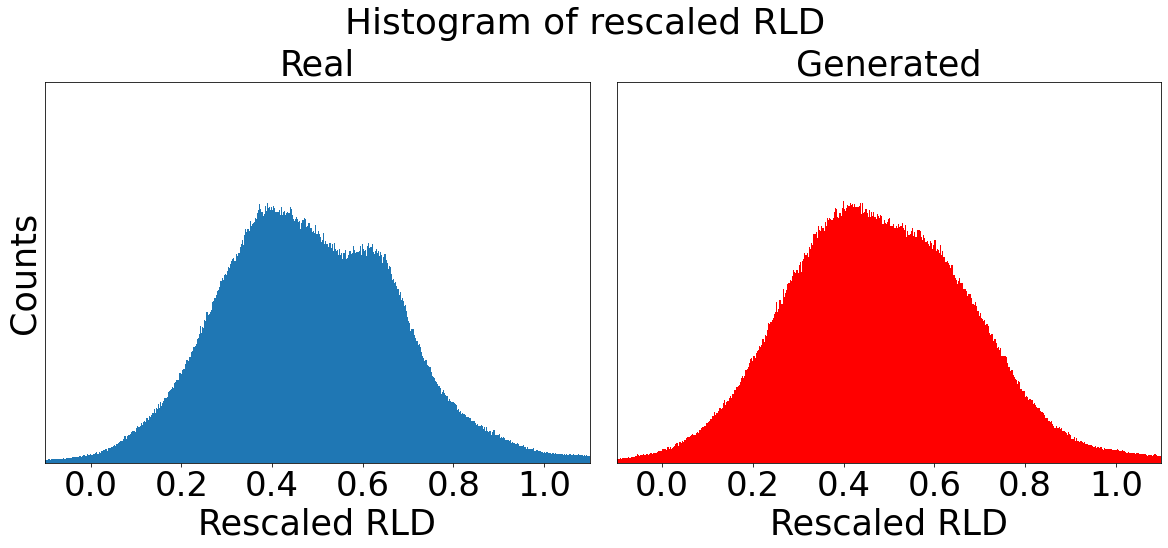

In [39]:
numBin = int((np.max(rld.flatten())-np.min(rld.flatten()))/0.005)
plot_hist_re_rld(rld, genaugx, 3000)

In [40]:
#Validate performance of network by comparing distribution of real and fake

real_corr = np.zeros((rld.shape[0], rld.shape[0]))
for i in range(rld.shape[0]):
    for j in range(rld.shape[0]):
        tmp1, tmp2 = rld[i], rld[j]
        real_corr[i,j] = stats.pearsonr(tmp1, tmp2)[0]

aug_corr = np.zeros((rld.shape[0], rld.shape[0]))
for i in range(len(aug_corr)):
    for j in range(len(aug_corr)):
        tmp1, tmp2 = rld[i], genaugx[j]
        aug_corr[i,j] = stats.pearsonr(tmp1,tmp2)[0]

In [41]:
def plot_hist_corr(real, fake, bins=100):
    plt.figure(figsize=(20,7))
    plt.suptitle('Histogram of correlation coefficient', fontsize=36, y=1.03)
    plt.subplot(1,2,1)
    plt.hist(real.flatten(), bins=bins)
    plt.xlim(-1,1)
    plt.xticks([-1, -0.5, 0.0, 0.5,  1], fontsize=24)
    plt.yticks([])
    plt.xlabel('Correlation', fontsize=35)
    plt.ylabel('Counts', fontsize=35)
    plt.title('Real vs. Real', fontsize=35)

    plt.subplot(1,2,2)
    plt.subplots_adjust(wspace=0.12)
    plt.hist(fake.flatten(), bins=bins, color='red')
    plt.xlim(-1,1)
    plt.xticks([-1, -0.5, 0.0, 0.5,  1], fontsize=24)
    plt.yticks([])
    plt.xlabel('Correlation', fontsize=35)
    plt.title('Real vs. Generated', fontsize=35)
    plt.plot()

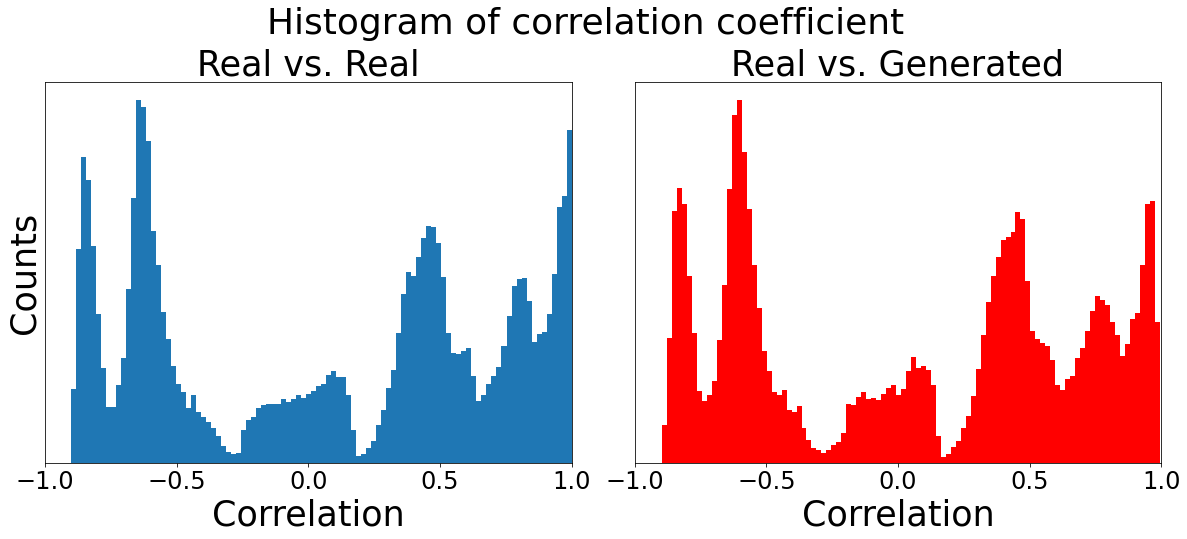

In [42]:
plot_hist_corr(real_corr, aug_corr)

In [43]:
# Label Indexing

WT3M = np.array([0,37,65,84,94])
AD3M = np.add(WT3M, 95)
WT6M = np.add(WT3M, 2*95)
AD6M = np.add(WT3M, 3*95)
Aug_WT3M = np.arange(95)
Aug_AD3M = np.add(Aug_WT3M,95)
Aug_WT6M = np.add(Aug_WT3M,2*95)
Aug_AD6M = np.add(Aug_WT3M,3*95)


print(rld.shape)
print(WT3M.shape,Aug_WT3M.shape)
OnlyAug_WT3M = [e for e in Aug_WT3M if e not in WT3M ]
OnlyAug_WT6M = [e for e in Aug_WT6M if e not in WT6M ]
OnlyAug_AD3M = [e for e in Aug_AD3M if e not in AD3M ]
OnlyAug_AD6M = [e for e in Aug_AD6M if e not in AD6M ]
print(np.shape(OnlyAug_WT3M),OnlyAug_WT3M)
print(np.shape(OnlyAug_WT6M),OnlyAug_WT6M)
print(np.shape(OnlyAug_AD3M),OnlyAug_AD3M)
print(np.shape(OnlyAug_AD6M),OnlyAug_AD6M)
x_WT3M = rld[WT3M,:]
x_WT6M = rld[WT6M,:]
x_AD3M = rld[AD3M,:]
x_AD6M = rld[AD6M,:]
x_OnlyAug_WT3M = rld[OnlyAug_WT3M,:]
x_OnlyAug_WT6M = rld[OnlyAug_WT6M,:]
x_OnlyAug_AD3M = rld[OnlyAug_AD3M,:]
x_OnlyAug_AD6M = rld[OnlyAug_AD6M,:]
x_real20=np.concatenate((x_WT3M,x_WT6M,x_AD3M,x_AD6M), axis=0)
x_OnlyAug360=np.concatenate((x_OnlyAug_WT3M,x_OnlyAug_WT6M,x_OnlyAug_AD3M,x_OnlyAug_AD6M),axis=0)
print(x_real20.shape,x_OnlyAug360.shape)

(380, 3767)
(5,) (95,)
(90,) [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93]
(90,) [191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 275, 276, 277, 278, 279, 280, 281, 282, 283]
(90,) [96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,

In [44]:
n_noise = 10000
  
Fake10000z = get_noise(n_noise)
Fake10000 = generator(Fake10000z, training=False)
print(Fake10000z.shape, Fake10000.shape)

(10000, 100) (10000, 3767)


In [45]:
from scipy import stats
n_real = 20
fake_real_corr = np.zeros((n_real,))
Fake20z, Fake20x = np.zeros((n_real,Fake10000z.shape[1])), np.zeros((n_real,Fake10000.shape[1]))
print (fake_real_corr.shape)
print (Fake20z.shape,Fake20x.shape)
print (x_real20.shape)

for i in range(1):
    scorr_ary = np.zeros((n_noise,))
    tmp1 = x_real20[i]
    for j in range(n_noise):
        tmp2 = Fake10000[j]
        scorr_ary[j] = stats.pearsonr(tmp1, tmp2)[0]
    smaxidx = np.argsort(scorr_ary)[-10:]
    print(np.max(scorr_ary))
    Fake20z[i]=np.average(tf.gather(Fake10000z, smaxidx), axis=0)
    Fake20x[i]=generator(np.reshape(Fake20z[i],(1,100)), training=False)
    fake_real_corr[i] = stats.pearsonr(tmp1, Fake20x[i])[0]
    print(tmp1)
    print(Fake20x[i])
    print(fake_real_corr[i])

(20,)
(20, 100) (20, 3767)
(20, 3767)
0.9717218409051929
[0.4784544  0.6569912  0.62883687 ... 0.50901043 0.43758258 0.4316747 ]
[0.46876925 0.69240719 0.61156559 ... 0.60636604 0.44443023 0.41909173]
0.9718193917726575


(20,)
0.9718193917726575
0.0


[]

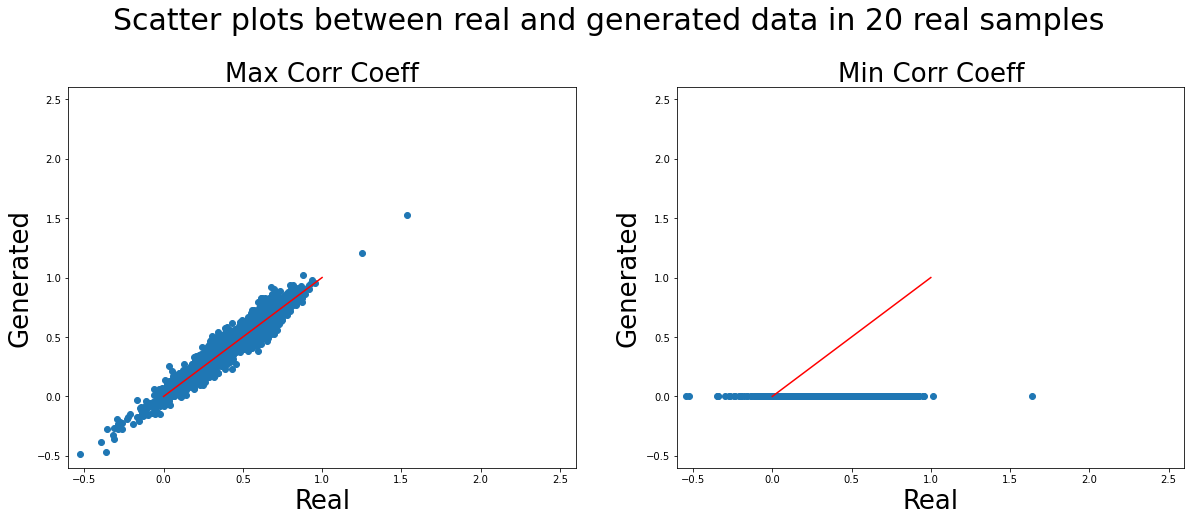

In [46]:
print(fake_real_corr.shape)  # for a given real data
print(np.max(fake_real_corr,axis=0))
print(np.min(fake_real_corr,axis=0))
real_min = np.argmin(fake_real_corr)
real_max = np.argmax(fake_real_corr)

plt.figure(figsize=(20,7))
plt.suptitle('Scatter plots between real and generated data in 20 real samples',fontsize=30,y=1.04)

plt.subplot(121)
plt.scatter(x_real20[real_max],Fake20x[real_max])
plt.xlim(-0.6,2.6)
plt.ylim(-0.6,2.6)
plt.xlabel('Real',fontsize=26)
plt.ylabel('Generated',fontsize=26)
plt.title('Max Corr Coeff',fontsize=26)
plt.plot([0,1],color='red')

plt.subplot(122)
plt.scatter(x_real20[real_min],Fake20x[real_min])
plt.xlim(-0.6,2.6)
plt.ylim(-0.6,2.6)
plt.xlabel('Real',fontsize=26)
plt.ylabel('Generated',fontsize=26)
plt.title('Min Corr Coeff',fontsize=26)
plt.plot([0,1],color='red')
plt.plot()

In [47]:
tsne_real20 = tsne.fit_transform(x_real20)

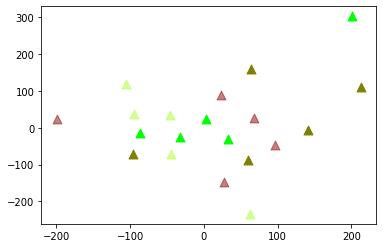

In [48]:
plt.scatter(tsne_real20[0:5,0], tsne_real20[0:5,1], alpha=1.0, s=80, marker='^', c='lime')
plt.scatter(tsne_real20[5:10,0], tsne_real20[5:10,1], alpha=1.0, s=80, marker='^', c='olive')
plt.scatter(tsne_real20[10:15,0], tsne_real20[10:15,1], alpha=0.5, s=80, marker='^', c='darkred')
plt.scatter(tsne_real20[15:20,0], tsne_real20[15:20,1], alpha=0.5, s=80, marker='^', c='greenyellow')

In [49]:
tsne_onlyaug = tsne.fit_transform(x_OnlyAug360)

(-60.0, 60.0)

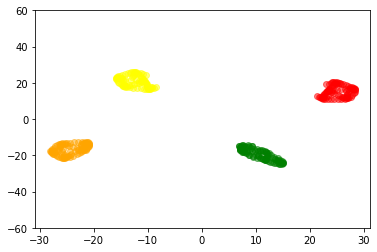

In [50]:
naug=90
plt.scatter(tsne_onlyaug[0:naug,0], tsne_onlyaug[0:naug,1], alpha=0.5, c='yellow')
plt.scatter(tsne_onlyaug[naug:2*naug,0], tsne_onlyaug[naug:2*naug,1], alpha=0.5, c='orange')
plt.scatter(tsne_onlyaug[2*naug:3*naug,0], tsne_onlyaug[2*naug:3*naug,1], alpha=0.5, c='red')
plt.scatter(tsne_onlyaug[3*naug:4*naug,0], tsne_onlyaug[3*naug:4*naug,1], alpha=0.5, c='green')
plt.ylim(-60,60)

In [51]:
# The top 10 averaged fake of real data
fakex = np.concatenate((x_real20,x_OnlyAug360,Fake20x), axis=0)
fakex.shape
n_onlyaug = 360

In [52]:
tsne_fakex = tsne.fit_transform(fakex)

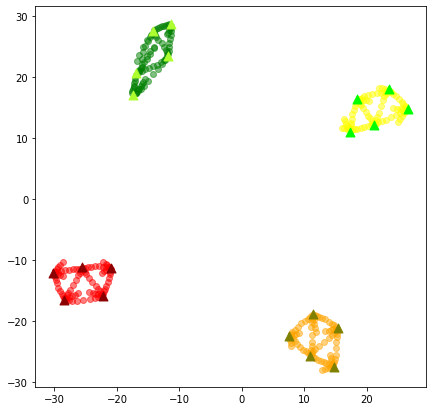

In [53]:
plt.figure(figsize=(7,7))
plt.scatter(tsne_fakex[n_real:n_real+naug,0], tsne_fakex[n_real:n_real+naug,1], alpha=0.5, c='yellow')
plt.scatter(tsne_fakex[n_real+naug:n_real+2*naug,0], tsne_fakex[n_real+naug:n_real+2*naug,1], alpha=0.5, c='orange')
plt.scatter(tsne_fakex[n_real+2*naug:n_real+3*naug,0], tsne_fakex[n_real+2*naug:n_real+3*naug,1], alpha=0.5, c='red')
plt.scatter(tsne_fakex[n_real+3*naug:n_real+4*naug,0], tsne_fakex[n_real+3*naug:n_real+4*naug,1], alpha=0.5, c='green')

plt.scatter(tsne_fakex[0:5,0], tsne_fakex[0:5,1], alpha=1.0, s=80, marker='^', c='lime')
plt.scatter(tsne_fakex[5:10,0], tsne_fakex[5:10,1], alpha=1.0, s=80, marker='^', c='olive')
plt.scatter(tsne_fakex[10:15,0], tsne_fakex[10:15,1], alpha=1.0, s=80, marker='^', c='darkred')
plt.scatter(tsne_fakex[15:20,0], tsne_fakex[15:20,1], alpha=1.0, s=80, marker='^', c='greenyellow')


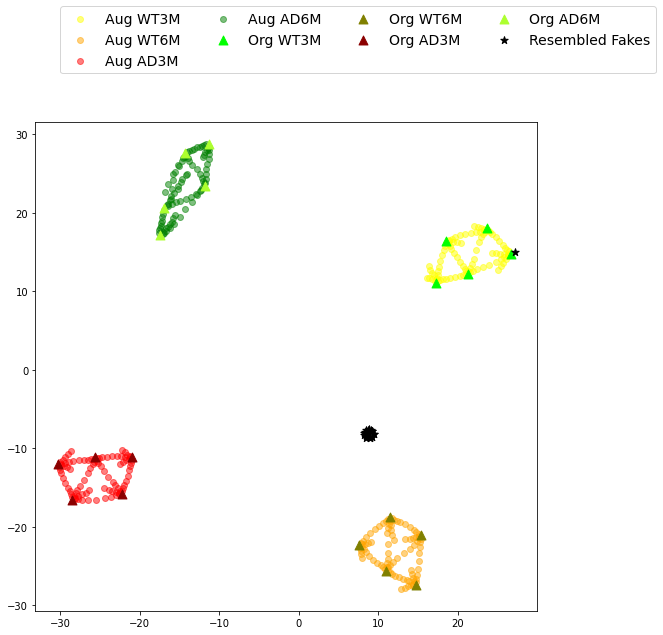

In [54]:
plt.figure(figsize=(9,9))
#plt.ylim(-60,60)
plt.scatter(tsne_fakex[n_real:n_real+naug,0], tsne_fakex[n_real:n_real+naug,1], alpha=0.5, c='yellow')
plt.scatter(tsne_fakex[n_real+naug:n_real+2*naug,0], tsne_fakex[n_real+naug:n_real+2*naug,1], alpha=0.5, c='orange')
plt.scatter(tsne_fakex[n_real+2*naug:n_real+3*naug,0], tsne_fakex[n_real+2*naug:n_real+3*naug,1], alpha=0.5, c='red')
plt.scatter(tsne_fakex[n_real+3*naug:n_real+4*naug,0], tsne_fakex[n_real+3*naug:n_real+4*naug,1], alpha=0.5, c='green')

plt.scatter(tsne_fakex[0:5,0], tsne_fakex[0:5,1], alpha=1.0, s=80, marker='^', c='lime')
plt.scatter(tsne_fakex[5:10,0], tsne_fakex[5:10,1], alpha=1.0, s=80, marker='^', c='olive')
plt.scatter(tsne_fakex[10:15,0], tsne_fakex[10:15,1], alpha=1.0, s=80, marker='^', c='darkred')
plt.scatter(tsne_fakex[15:20,0], tsne_fakex[15:20,1], alpha=1.0, s=80, marker='^', c='greenyellow')

plt.scatter(tsne_fakex[n_real+4*naug:2*n_real+4*naug,0], tsne_fakex[n_real+4*naug:2*n_real+4*naug,1], 
            alpha=1.0, s=60, marker='*', c='black')

plt.legend(['Aug WT3M', 'Aug WT6M', 'Aug AD3M', 'Aug AD6M',
           'Org WT3M', 'Org WT6M', 'Org AD3M', 'Org AD6M', 
           'Resembled Fakes'], ncol=4, bbox_to_anchor=(1.25, 1.25), fontsize=14)

Text(0.555, 0.42, 'D')

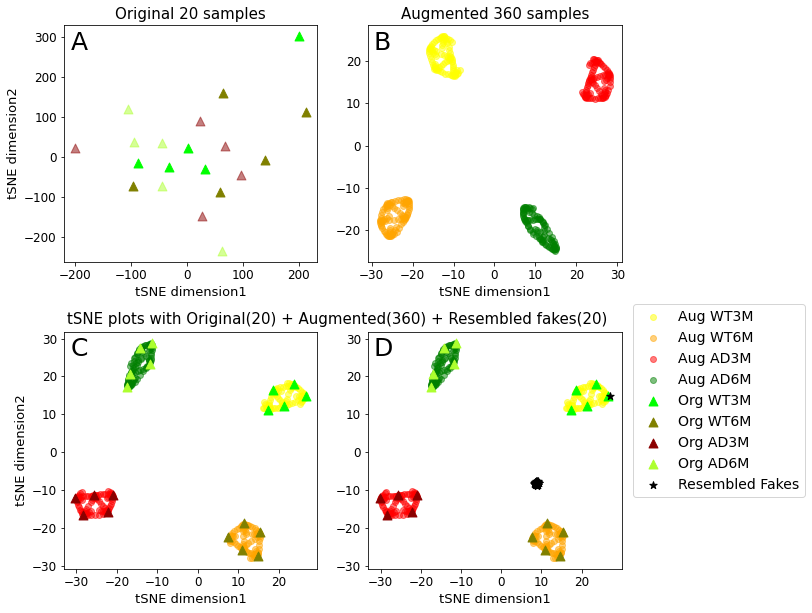

In [55]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.scatter(tsne_real20[0:5,0], tsne_real20[0:5,1], alpha=1.0, s=80, marker='^', c='lime')
plt.scatter(tsne_real20[5:10,0], tsne_real20[5:10,1], alpha=1.0, s=80, marker='^', c='olive')
plt.scatter(tsne_real20[10:15,0], tsne_real20[10:15,1], alpha=0.5, s=80, marker='^', c='darkred')
plt.scatter(tsne_real20[15:20,0], tsne_real20[15:20,1], alpha=0.5, s=80, marker='^', c='greenyellow')
plt.xlabel('tSNE dimension1', fontsize=13)
plt.ylabel('tSNE dimension2', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Original 20 samples',fontsize=15)

plt.subplot(2,2,2)
naug=90
plt.scatter(tsne_onlyaug[0:naug,0], tsne_onlyaug[0:naug,1], alpha=0.5, c='yellow')
plt.scatter(tsne_onlyaug[naug:2*naug,0], tsne_onlyaug[naug:2*naug,1], alpha=0.5, c='orange')
plt.scatter(tsne_onlyaug[2*naug:3*naug,0], tsne_onlyaug[2*naug:3*naug,1], alpha=0.5, c='red')
plt.scatter(tsne_onlyaug[3*naug:4*naug,0], tsne_onlyaug[3*naug:4*naug,1], alpha=0.5, c='green')
plt.xlabel('tSNE dimension1', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Augmented 360 samples',fontsize=15)

plt.subplot(2,2,3)
plt.scatter(tsne_fakex[n_real:n_real+naug,0], tsne_fakex[n_real:n_real+naug,1], alpha=0.5, c='yellow')
plt.scatter(tsne_fakex[n_real+naug:n_real+2*naug,0], tsne_fakex[n_real+naug:n_real+2*naug,1], alpha=0.5, c='orange')
plt.scatter(tsne_fakex[n_real+2*naug:n_real+3*naug,0], tsne_fakex[n_real+2*naug:n_real+3*naug,1], alpha=0.5, c='red')
plt.scatter(tsne_fakex[n_real+3*naug:n_real+4*naug,0], tsne_fakex[n_real+3*naug:n_real+4*naug,1], alpha=0.5, c='green')

plt.scatter(tsne_fakex[0:5,0], tsne_fakex[0:5,1], alpha=1.0, s=80, marker='^', c='lime')
plt.scatter(tsne_fakex[5:10,0], tsne_fakex[5:10,1], alpha=1.0, s=80, marker='^', c='olive')
plt.scatter(tsne_fakex[10:15,0], tsne_fakex[10:15,1], alpha=1.0, s=80, marker='^', c='darkred')
plt.scatter(tsne_fakex[15:20,0], tsne_fakex[15:20,1], alpha=1.0, s=80, marker='^', c='greenyellow')
plt.xlabel('tSNE dimension1', fontsize=13)
plt.ylabel('tSNE dimension2', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(2,2,4)

ps1 = plt.scatter(tsne_fakex[n_real:n_real+naug,0], tsne_fakex[n_real:n_real+naug,1], alpha=0.5, c='yellow')
ps2 = plt.scatter(tsne_fakex[n_real+naug:n_real+2*naug,0], tsne_fakex[n_real+naug:n_real+2*naug,1], alpha=0.5, c='orange')
ps3 = plt.scatter(tsne_fakex[n_real+2*naug:n_real+3*naug,0], tsne_fakex[n_real+2*naug:n_real+3*naug,1], alpha=0.5, c='red')
ps4 = plt.scatter(tsne_fakex[n_real+3*naug:n_real+4*naug,0], tsne_fakex[n_real+3*naug:n_real+4*naug,1], alpha=0.5, c='green')

ps5 = plt.scatter(tsne_fakex[0:5,0], tsne_fakex[0:5,1], alpha=1.0, s=80, marker='^', c='lime')
ps6 = plt.scatter(tsne_fakex[5:10,0], tsne_fakex[5:10,1], alpha=1.0, s=80, marker='^', c='olive')
ps7 = plt.scatter(tsne_fakex[10:15,0], tsne_fakex[10:15,1], alpha=1.0, s=80, marker='^', c='darkred')
ps8 = plt.scatter(tsne_fakex[15:20,0], tsne_fakex[15:20,1], alpha=1.0, s=80, marker='^', c='greenyellow')

ps9 = plt.scatter(tsne_fakex[n_real+4*naug:2*n_real+4*naug,0], tsne_fakex[n_real+4*naug:2*n_real+4*naug,1], alpha=1.0, s=60, marker='*', c='black')
plt.xlabel('tSNE dimension1', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.legend([ps1,ps2,ps3,ps4,ps5,ps6,ps7,ps8,ps9],
           ['Aug WT3M', 'Aug WT6M', 'Aug AD3M', 'Aug AD6M',
           'Org WT3M', 'Org WT6M', 'Org AD3M', 'Org AD6M', 
           'Resembled Fakes'], 
           bbox_to_anchor=(1.75, 1.15), fontsize=14)

plt.subplots_adjust(hspace=0.3)

plt.figtext(0.13,0.465,'tSNE plots with Original(20) + Augmented(360) + Resembled fakes(20)',fontsize=15)
plt.figtext(0.135,0.845,'A',fontsize=25)
plt.figtext(0.555,0.845,'B',fontsize=25)
plt.figtext(0.135,0.42,'C',fontsize=25)
plt.figtext(0.555,0.42,'D',fontsize=25)

In [56]:
epochs = np.arange(500, 300001, 500)
Pheno_index = [WT3M,WT6M,AD3M,AD6M]
Pheno_rld = [x_WT3M,x_WT6M,x_AD3M,x_AD6M]

In [ ]:
if is_training :
    AllE_Fake20z, AllE_Fake20x, AllE_Fake20_corr = [], [], []
    for ep in range(len(epochs)):
        ckpath = checkpoint_dir + "/cp-" + str(epochs[ep]) + '.ckpt-' + str(ep+1)
        print("restoring from " + ckpath)
        checkpoint.restore(ckpath)


        noise_tmp = get_noise(n_noise)
        gen_tmp = generator(noise_tmp, training=False)
        print(noise_tmp.shape, gen_tmp.shape)
        OneE_Fake20z, OneE_Fake20x, OneE_Fake20_corr = [], [], []
        for pheno in range (len(Pheno_index)):
            tmpz_rld, tmpx_rld, tmp_corr = [], [], []
            for i in range (len(Pheno_index[pheno])):
                scorr_arr = np.zeros((n_noise,))
                pheno1_rld = Pheno_rld[pheno][i]
                for j in range (n_noise):
                    scorr_arr[j] = stats.pearsonr(pheno1_rld, gen_tmp[j])[0]
                smaxidx = np.argsort(scorr_arr)[-10:]
                tmpz_avg = np.average(tf.gather(noise_tmp, smaxidx), axis=0)
                tmpx_avg = generator(np.reshape(tmpz_avg, (1, 100)), training=False)
                tmpz_rld.append(tmpz_avg)
                tmpx_rld.append(tmpx_avg)
                scorr_avg = stats.pearsonr(pheno1_rld, tmpx_avg[0])[0]
                tmp_corr.append(scorr_avg)

            OneE_Fake20z.append(tmpz_rld)
            OneE_Fake20x.append(tmpx_rld)
            OneE_Fake20_corr.append(tmp_corr)
        AllE_Fake20z.append(OneE_Fake20z)
        AllE_Fake20x.append(OneE_Fake20x)
        AllE_Fake20_corr.append(OneE_Fake20_corr)

    AllE_Fake20z, AllE_Fake20x, AllE_Fake20_corr = np.array(AllE_Fake20z), np.array(AllE_Fake20x), np.array(AllE_Fake20_corr)
    print(AllE_Fake20z.shape, AllE_Fake20x.shape, AllE_Fake20_corr.shape)
    #save value
    np.savez(sub_path+'/AllE_Fake20.npz', AllE_Fake20z=AllE_Fake20z,AllE_Fake20x=AllE_Fake20x,
             AllE_Fake20_corr=AllE_Fake20_corr) 

restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-500.ckpt-1
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-1000.ckpt-2
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-1500.ckpt-3
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-2000.ckpt-4
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-2500.ckpt-5
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-3000.ckpt-6
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-3500.ckpt-7
(10000, 100) (10000, 3767)
restoring from training_data/Tau_un

(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-30000.ckpt-60
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-30500.ckpt-61
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-31000.ckpt-62
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-31500.ckpt-63
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-32000.ckpt-64
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-32500.ckpt-65
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-33000.ckpt-66
(10000, 100) (10000,

(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-59500.ckpt-119
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-60000.ckpt-120
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-60500.ckpt-121
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-61000.ckpt-122
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-61500.ckpt-123
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-62000.ckpt-124
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-62500.ckpt-125
(10000, 100) 

restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-88500.ckpt-177
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-89000.ckpt-178
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-89500.ckpt-179
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-90000.ckpt-180
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-90500.ckpt-181
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-91000.ckpt-182
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-91500.ckpt-183
(10000, 100) (10000, 3767)
restoring fro

restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-117500.ckpt-235
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-118000.ckpt-236
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-118500.ckpt-237
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-119000.ckpt-238
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-119500.ckpt-239
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-120000.ckpt-240
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-120500.ckpt-241
(10000, 100) (10000, 3767)
restor

(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-146500.ckpt-293
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-147000.ckpt-294
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-147500.ckpt-295
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-148000.ckpt-296
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-148500.ckpt-297
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-149000.ckpt-298
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-149500.ckpt-299
(10000

(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-175500.ckpt-351
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-176000.ckpt-352
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-176500.ckpt-353
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-177000.ckpt-354
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-177500.ckpt-355
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-178000.ckpt-356
(10000, 100) (10000, 3767)
restoring from training_data/Tau_union_LFC03_G3767_G450D270_300k/yours_dir/training_checkpoints/cp-178500.ckpt-357
(10000

In [ ]:
Reload = np.load(sub_path+'/AllE_Fake20.npz')
ReAllE_Fake20z, ReAllE_Fake20x, ReAllE_Fake20_corr = Reload['AllE_Fake20z'],Reload['AllE_Fake20x'],Reload['AllE_Fake20_corr']
print(ReAllE_Fake20z.shape, ReAllE_Fake20x.shape, ReAllE_Fake20_corr.shape)

In [ ]:
suptitle=['[WT3M]','[WT6M]','[AD3M]','[AD6M]']
plt.figure(figsize=(20,28))
for i in range(4):
    plt.subplot(5,1,i+1)
    plt.subplots_adjust(hspace=0.35)
    plt.title(suptitle[i], fontsize=20, loc='left', fontweight= 'bold')
    plt.ylim(0.7,1.0)
    plt.xlim(0,600)
    plt.yticks(fontweight= 'bold',fontsize=24)
    plt.xticks([0,50,100,150,200,250,300,350,400,450,500,550,600],
               ['0','25K','50K','75K','100K','125K','150K','175K','200K','225K','250K','275K','300K'], 
               fontweight= 'bold',fontsize=24)
    plt.grid(alpha=0.3)
    for j in range(4):
        plt.plot(ReAllE_Fake20_corr[:,i,j], linewidth=3.0)

plt.subplot(5,1,5)
plt.title('[Average]', fontsize=20, loc='left', fontweight= 'bold')
plt.ylim(0.7,1.0)
plt.xlim(0,600)
plt.yticks(fontweight= 'bold',fontsize=24)
plt.xticks([0,50,100,150,200,250,300,350,400,450,500,550,600],
           ['0','25K','50K','75K','100K','125K','150K','175K','200K','225K','250K','275K','300K'], 
           fontweight= 'bold',fontsize=24)
plt.grid(alpha=0.3)
plt.plot(np.average(np.average(ReAllE_Fake20_corr,axis=2),axis=1), linewidth=3.0)


In [ ]:
#Interpolation setting 
cond_list = [Aug_WT3M,Aug_WT6M,Aug_AD3M,Aug_AD6M]
Latent_inlist = [[cond_list[0], cond_list[1]],[cond_list[2], cond_list[3]],
                 [cond_list[0], cond_list[2]],[cond_list[1], cond_list[3]]]


union_condition = ['WT3MtoWT6M','AD3MtoAD6M','WT3MtoAD3M','WT6MtoAD6M']

start_ep = 225000
ep_ary = np.arange(0,50500,500)+start_ep
start_ckpt = int(start_ep/500)
LatInt_epoch_txt= str(start_ep)[0:3]+'K'+str(start_ep+50000)[0:3]+'K'
print(LatInt_epoch_txt)

In [ ]:
#Interpolation processing
if is_interpolation :
    from multiprocessing import Pool

    first_start = time.time()
    #your cpu core setting
    num_cores = (os.cpu_count()*2)-10

    inlist = Latent_inlist
    def work_func(j):

        scorr_ary = stats.pearsonr(rld[s_[s]], tmp_genx_as_array[j])[0]
        ecorr_ary = stats.pearsonr(rld[e_[s]], tmp_genx_as_array[j])[0]

        return [scorr_ary,ecorr_ary]

    for i in range(len(inlist)):
        LatInt_z, LatInt_avgz, LatInt_genx  = [], [], []
        print("Start " + union_condition[i])

        for ep in range(len(ep_ary)):
            #if ep==1: break;
            ckpath = checkpoint_dir + "/cp-" + str(ep_ary[ep]) + '.ckpt-' + str(ep+start_ckpt)
            print("restoring from " + ckpath)
            checkpoint.restore(ckpath)

            tmpz = get_noise(n_noise)
            tmp_genx = generator(tmpz, training=False)
            #Logic to avoid conflicts between TensorFlow variables and parallel processing for parallel processing
            tmp_genx_as_array=np.array(tmp_genx,np.float32)
            gens, gene = [], []

            s_, e_ = inlist[i][0], inlist[i][1]

            tmps, tmpe = [], []
            for s in range(len(s_)):
                #if s==1: break;
                scorr_ary, ecorr_ary = np.zeros((n_noise,)), np.zeros((n_noise,)) 
                #parallel processing
                if __name__ == "__main__":             

                    pool = Pool(num_cores)
                    work_result=np.array(pool.map(work_func,range(10000)))
                    pool.terminate()

                smaxidx = np.argsort(work_result.T[0])[-10:]
                emaxidx = np.argsort(work_result.T[1])[-10:]
                tmps.append(np.average(tf.gather(tmpz, smaxidx),axis=0))
                tmpe.append(np.average(tf.gather(tmpz, emaxidx),axis=0))
            gens.append(tmps)
            gene.append(tmpe)

            gens, gene = np.array(gens), np.array(gene)
       
            delta_z = np.average(gene,axis=1)-np.average(gens,axis=1)
            inter_ = np.linspace(0., 1., num=101)

            LatInt_z.append([gens, gene])
            LatInt_avgz.append(delta_z)

            #generate fake by interpolating latent vector
            genx = []
            for ag in range(gens.shape[0]): #age
                tmpgenx = []
                for aug_sp in range(gens.shape[1]): #aug_samples
                    ttmpgenx = []
                    #interpolate
                    for z_ in inter_: 
                        tmpz = gens[ag][aug_sp] + (delta_z[ag]*z_)
                        tmpx = generator(tmpz.reshape((1,100)), training=False) 
                        ttmpgenx.append(tmpx)
                    tmpgenx.append(ttmpgenx)
                genx.append(tmpgenx)
            genx = np.array(genx)
            genx = genx.reshape((len(delta_z), np.shape(gens)[1],len(inter_), p))

            LatInt_genx.append(genx)

        LatInt_z, LatInt_avgz = np.array(LatInt_z), np.array(LatInt_avgz)
        LatInt_genx = np.array(LatInt_genx) 
      
        file_name = '/LatInt_'+LatInt_epoch_txt+'_'+union_condition[i]+'.npz'
        np.savez(sub_path+file_name, LatInt_genx=LatInt_genx) 

    elapsed_time = time.time() - first_start
    hours, rem = divmod(elapsed_time, 3600)
    minutes, seconds = divmod(rem, 60)
    print ("Elapsed time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

In [ ]:
genx_A, genx_S=[], []
for i in range(len(union_condition)) :
    #if i==1 : break
    file_name = '/LatInt_'+LatInt_epoch_txt+'_'+union_condition[i]+'.npz'
    Reload_LatInt = np.load(sub_path+file_name)
    Rel_LatInt_genx = Reload_LatInt['LatInt_genx']
    genx_A_ind = np.average(np.average(Rel_LatInt_genx, axis=2), axis=0)
    genx_S_ind = np.std(np.average(Rel_LatInt_genx, axis=2), axis=0)
    genx_A.append(genx_A_ind[0])
    genx_S.append(genx_S_ind[0])
genx_A=np.array(genx_A)
genx_S=np.array(genx_S)
print(genx_A.shape,genx_S.shape)
smaple_list={'WT3M' : WT3M, 'WT6M' : WT6M, 'AD3M' : AD3M,'AD6M' : AD6M}

# 4. 4way Transition curves

In [ ]:
genx_A_reserved = np.array([np.flip(genx_A[3],axis=0),np.flip(genx_A[0],axis=0),genx_A[2],genx_A[1]])
genx_A_sw1 = genx_A_reserved.swapaxes(1,2)
genx_A_sw2 = genx_A_sw1.swapaxes(0,1)
genx_A_4way = genx_A_sw2.reshape(3767,-1)
print(union_condition)
print(genx_A_4way)

In [ ]:
#APC(Affinity Propagation Clustering)
cluster = AffinityPropagation(random_state=0).fit(genx_A_4way)
cluster_id = pd.DataFrame(cluster.labels_)
cluster_id.columns = ['mapping']

In [ ]:
#pattern setting
pattern_marking_data= [[3, 10, 15, 16, 18, 22, 24, 28, 30, 32],
                        [4, 7, 8, 9, 11, 13, 14, 17, 20, 21, 34],
                        [2, 5, 6, 19, 23, 27],
                        [50,51,42,45,48],
                        [54,55],
                        [35, 37, 41, 43, 44],
                        [12,25,29,39],
                        [26,33,36],
                       [0,1,31,38,40,46,47,49,52,53]]

In [ ]:
#gene mapping index data 
gene_index_data = pd.DataFrame(data=genelist,columns=['gene_symbol'])
gene_index_data["gene_id"]=np.arange(len(gene_index_data))
gene_DKres_data = pd.read_csv('Tau_Union_res_LFC03_remove_all_case_3767genes.csv', delimiter=',')

gene_DKres_data = gene_DKres_data.rename(columns={'X':'ensemble_id'})

for i in range(len(gene_DKres_data)):
    get_compare_data = gene_DKres_data.iloc[i]
    get_comparison_value = get_compare_data['log2FoldChange']
    get_compare_name = get_compare_data['gene_name']
    get_mapping_id = gene_index_data[gene_index_data['gene_symbol']==get_compare_name].index  
    
gene_index_data

In [ ]:
def marking_mapping_plot(genx_A_reshape_cluster, cluster_id, cluster_centers_indices, mapping_pattern, title,
                         marking_pattern_fl, index):
    
    n_clusters_ = len(mapping_pattern)
    s_n_clusters_= len(mapping_pattern)
    height = n_clusters_//11  
    if n_clusters_%11 : height=height+1
    else : height=height+1
    width=100 
    if n_clusters_ < 11 :
        height=height+1
        s_n_clusters_=11
    plt.clf()
    plt.figure(figsize=(width,15))
    print(title)
    for i in range(s_n_clusters_):
        
        plt.subplot((s_n_clusters_//11)+1,11,i+1)
        plt.subplots_adjust(wspace=0.2, hspace=0.2)
        
        #if i>n_clusters_-1 : continue
        if n_clusters_>i :
            num_pattern = marking_pattern_fl.index(mapping_pattern[i])+1
            cluster_mapping_index=np.array(cluster_id[cluster_id['mapping']==mapping_pattern[i]].index)
            plt.title('APC '+str(num_pattern)+'('+str(len(cluster_mapping_index))+')', 
                      fontsize=40, fontweight= 'bold')

        
            #print(cluster_mapping_index)
            for j in range(len(cluster_mapping_index)):

                plt.plot(genx_A_reshape_cluster[cluster_mapping_index[j]], c='gray', alpha=0.5)  

                #plt.plot(genx_A[3][:,cluster_mapping_index[j]], c='gray', alpha=0.5)  

            plt.plot(genx_A_reshape_cluster[cluster_centers_indices[mapping_pattern[i]]], c='red', linewidth=3)

            plt.grid(True, axis='x',linewidth=3)
            
            plt.gca().spines['right'].set_visible(False) #오른쪽 테두리 제거
            plt.gca().spines['top'].set_visible(False) 
            plt.gca().spines['left'].set_linewidth(4) 
            plt.gca().spines['bottom'].set_linewidth(4)
      
            plt.xticks([0,100,202,303,404], ('AD6M', 'WT6M','WT3M','AD3M','AD6M'),fontsize=20,
                       fontweight= 'bold')
            plt.yticks(fontsize=30)
            
            if i==0 : plt.ylabel('Rescaled RLD', fontsize=40,fontweight= 'bold')
        else :
            plt.xticks([])
            plt.yticks([])
            plt.gca().spines['right'].set_visible(False) #오른쪽 테두리 제거
            plt.gca().spines['top'].set_visible(False) 
            plt.gca().spines['left'].set_linewidth(False) 
            plt.gca().spines['bottom'].set_linewidth(False)
    text_title = 'P'+str(index+1)

    plt.show()

In [ ]:
pattern_marking_data_flatten=[element for array in pattern_marking_data for element in array]
pattern_marking_name=['P1','P2','P3','P4','P5','P6','P7','P8','Others']

for i in range(len(pattern_marking_data)) :
    marking_mapping_plot(genx_A_4way, cluster_id,
                         cluster.cluster_centers_indices_,pattern_marking_data[i],pattern_marking_name[i],
                         pattern_marking_data_flatten,i)